In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba

 99% 1.31G/1.32G [00:11<00:00, 133MB/s]
100% 1.32G/1.32G [00:11<00:00, 124MB/s]


In [ ]:
!unzip -qq gender-recognition-200k-images-celeba.zip

In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import cv2
from IPython import display

In [ ]:
data_path = "/content/Dataset/Train"

train_images = []

for f in os.listdir(data_path):
  for im in os.listdir(os.path.join(data_path, f))[0:25000]:
      img = cv2.imread(os.path.join(data_path, f, im))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (64, 64))
      train_images.append(img)


In [ ]:
train_images = np.array(train_images)
print(train_images.shape)

(50000, 64, 64, 3)


<class 'numpy.ndarray'>
(50000, 64, 64, 3)


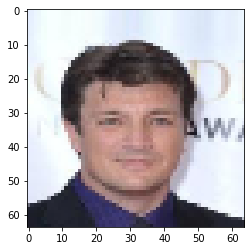

In [ ]:
plt.imshow(train_images[1])
print(type(train_images))
print(train_images.shape)
# print(train_images[1])

In [ ]:
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
generator_model = tf.keras.Sequential()
generator_model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Reshape((8, 8, 256)))
assert generator_model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

generator_model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 8, 8, 128)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 16, 16, 64)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 32, 32, 64)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator_model.output_shape == (None, 64, 64, 3)


In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator_model(noise, training=False)
plt.imshow(np.array((generated_image[0, :, :, :] * 127.5 ) + 127.5).astype(np.uint8), cmap = 'gray')


In [ ]:
discriminator_model = tf.keras.Sequential()
discriminator_model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                  input_shape=[64, 64, 3]))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Flatten())
discriminator_model.add(layers.Dense(1))

In [ ]:
decision = discriminator_model(generated_image)
print(decision)

tf.Tensor([[-0.00147952]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

In [ ]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator_model(noise, training=True)

      real_output = discriminator_model(images, training=True)
      fake_output = discriminator_model(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))
  # pred_img = np.zeros(64*3, 64*3, 3)
  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow((np.array(predictions[i, :, :, :] * 127.5 ) + 127.5 ).astype('uint8'), cmap = 'gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

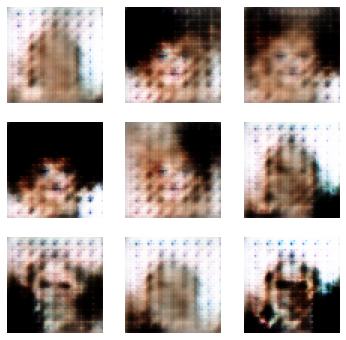

Time for epoch 6 is 73.16998314857483 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
# display_image(EPOCHS)

In [ ]:
anim_file = 'DCGAN-Celeb_A-02.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)